In [ ]:
# CHUNK 1 — Importar archivo Excel

from google.colab import drive
import pandas as pd

# Montar Drive
drive.mount('/content/drive')

# Ruta del archivo Excel
ruta_xlsx = '/content/drive/MyDrive/Datasets_Limpios/MICE.xlsx'

# Leer el Excel sin modificar su contenido
df = pd.read_excel(ruta_xlsx, sheet_name=0)

# Verificar carga
print(f"Excel importado correctamente con {df_xlsx.shape[0]} filas y {df_xlsx.shape[1]} columnas.")
df.head()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Excel importado correctamente con 190684 filas y 15 columnas.


,fecha_y_hora,wsr_km_h,wdr_azimutal,so2_ppb,no2_ppb,o3_ppb,pm10_ug_m3,pm2_5_ug_m3,tout_ºc,sr_kw_m2,__hoja,wsr_km_h_bin,tout_ºc_bin,wind_energy,indice_contaminacion,mes,estacion
0,2023-01-01 00:00:00,3.2,257.0,3.5,32.6,3.000000,110.0,46.844541,16.39,0.0,SURESTE,Medio-bajo,Medio-bajo,10.24,39.188908,1,Invierno
1,2023-01-01 01:00:00,3.3,278.0,3.4,30.3,3.000000,116.0,46.844541,15.17,0.0,SURESTE,Medio-bajo,Medio-bajo,10.89,39.908908,1,Invierno
2,2023-01-01 02:00:00,3.7,278.0,3.6,28.8,3.000000,117.0,46.844541,14.82,0.0,SURESTE,Medio-bajo,Medio-bajo,13.69,39.848908,1,Invierno
3,2023-01-01 03:00:00,3.6,197.0,3.8,29.1,3.000000,135.0,46.844541,15.51,0.0,SURESTE,Medio-bajo,Medio-bajo,12.96,43.548908,1,Invierno
4,2023-01-01 04:00:00,4.9,271.0,3.6,25.7,13.786247,132.0,46.844541,13.81,0.0,SURESTE,Medio-bajo,Bajo,24.01,44.386158,1,Invierno


Variables numéricas detectadas: 12


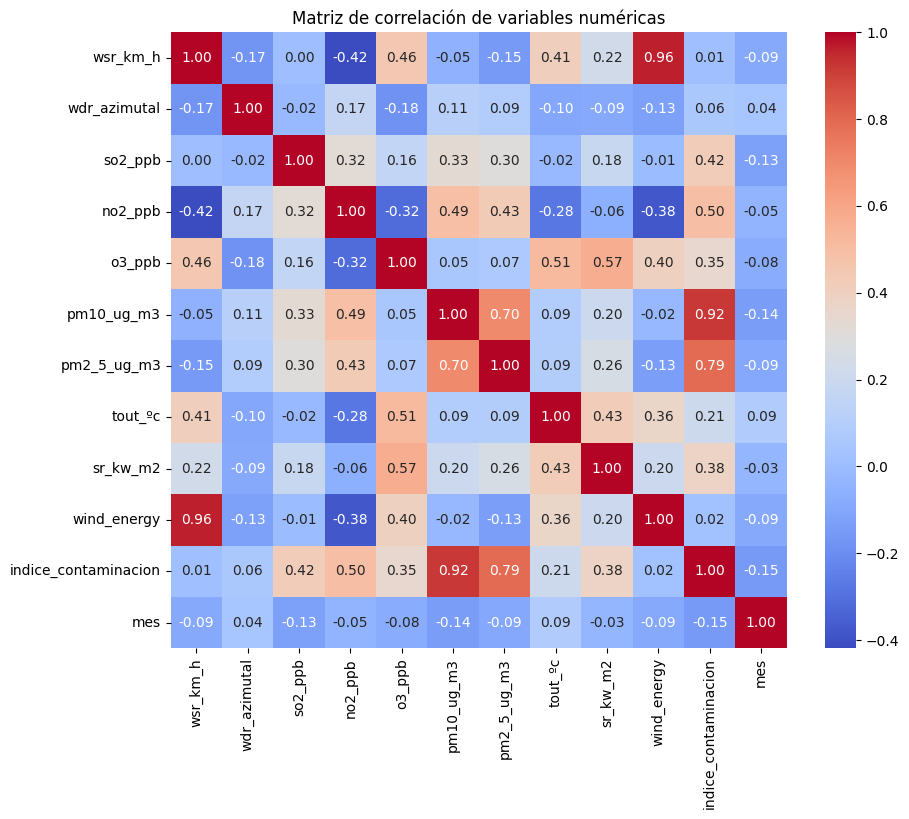

 Pares de variables altamente correlacionadas (>|0.8|):


,Variable_1,Variable_2,Correlación
8,wsr_km_h,wind_energy,0.963534
49,pm10_ug_m3,indice_contaminacion,0.918896


In [ ]:
# CHUNK 2 — Revisión de multicolinealidad y preparación para PCA o selección paso a paso

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

# Selecciona solo las variables numéricas
num_cols = df.select_dtypes(include=[np.number])
print(f"Variables numéricas detectadas: {len(num_cols.columns)}")

# Matriz de correlación
corr_matrix = num_cols.corr()

# Visualizar la correlación con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de correlación de variables numéricas")
plt.show()

# Identificar pares de variables altamente correlacionadas
umbral = 0.8
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Variable_1', 'Variable_2', 'Correlación']
altamente_corr = corr_pairs[abs(corr_pairs['Correlación']) > umbral]

print(" Pares de variables altamente correlacionadas (>|0.8|):")
display(altamente_corr)



In [ ]:
# CHUNK 3 — Eliminar variables de forma segura

import pandas as pd

# Detectar el DataFrame principal cargado
if 'df' in locals():
    data = df.copy()
elif 'df_csv' in locals():
    data = df_csv.copy()
elif 'df_xlsx' in locals():
    data = df_xlsx.copy()
else:
    raise NameError(" No se encontró ningún DataFrame cargado. Asegúrate de importar tu base primero.")

# Eliminar las variables especificadas (si existen)
cols_a_eliminar = ['indice_contaminacion', 'wind_energy'] # especificar datos altamente correlacionados para eliminar
data_sin_vars = data.drop(columns=[c for c in cols_a_eliminar if c in data.columns], errors='ignore')

# Verificar resultado
print(f" Variables eliminadas: {[c for c in cols_a_eliminar if c in data.columns]}")
print(f" Nuevo tamaño del DataFrame: {data_sin_vars.shape[0]} filas × {data_sin_vars.shape[1]} columnas")
print("\nPrimeras columnas disponibles:")
print(data_sin_vars.columns.tolist()[:10])
df = data_sin_vars.copy()

 Variables eliminadas: ['indice_contaminacion', 'wind_energy']
 Nuevo tamaño del DataFrame: 190685 filas × 15 columnas

Primeras columnas disponibles:
['fecha_y_hora', 'wsr_km_h', 'wdr_azimutal', 'so2_ppb', 'no2_ppb', 'o3_ppb', 'pm10_ug_m3', 'pm2_5_ug_m3', 'tout_ºc', 'sr_kw_m2']


In [ ]:
# CHUNK 4 — Preparar los datos para regresión logística
import pandas as pd
import numpy as np

# Usar el DataFrame limpio
if 'df' in locals():
    df_model = df.copy()
elif 'data' in locals():
    df_model = data.copy()
else:
    raise NameError(" No se encontró el DataFrame. Carga tu base antes de continuar.")

# Crear variable binaria de inversión térmica si no exist
if 'inversion_termica' not in df_model.columns:
    df_model['inversion_termica'] = np.where(df_model['mes'].isin([12, 1, 2]), 1, 0)

print(df_model['inversion_termica'].value_counts())


inversion_termica
0    145782
1     44903
Name: count, dtype: int64


In [ ]:
# CHUNK 5 — Modelo de regresión logística
import statsmodels.api as sm

# Variable dependiente
y = df_model['inversion_termica']

# Variables explicativas
X = df_model[['wsr_km_h', 'wdr_azimutal', 'sr_kw_m2', 'so2_ppb', 'no2_ppb', 'o3_ppb', 'pm2_5_ug_m3', 'mes', 'pm10_ug_m3']]

# Agregar constante
X = sm.add_constant(X)

# Ajustar el modelo
modelo_logit = sm.Logit(y, X).fit()

# Mostrar resultados
print(modelo_logit.summary())


Optimization terminated successfully.
         Current function value: 0.456407
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      inversion_termica   No. Observations:               190685
Model:                          Logit   Df Residuals:                   190675
Method:                           MLE   Df Model:                            9
Date:                Mon, 13 Oct 2025   Pseudo R-squ.:                  0.1638
Time:                        22:55:26   Log-Likelihood:                -87030.
converged:                       True   LL-Null:                   -1.0408e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.5950      0.030    -52.762      0.000      -1.654      -1.536
wsr_km_h        -0.0482

In [ ]:
# CHUNK 6 — Calcular odds ratio
odds_ratios = np.exp(modelo_logit.params)
print(" Odds Ratios (Exp(B)):\n")
print(odds_ratios)


 Odds Ratios (Exp(B)):

const           0.202904
wsr_km_h        0.952944
wdr_azimutal    1.000599
sr_kw_m2        0.271359
so2_ppb         1.309871
no2_ppb         1.056164
o3_ppb          0.995299
pm2_5_ug_m3     0.979328
mes             0.850540
pm10_ug_m3      1.005698
dtype: float64


In [ ]:
# CHUNK 7 — Evaluación del modelo
from sklearn.metrics import confusion_matrix, classification_report

# Predicciones de probabilidad y clasificación
y_pred_prob = modelo_logit.predict(X)
y_pred = (y_pred_prob >= 0.308).astype(int)

# Matriz de confusión
cm = confusion_matrix(y, y_pred)
print("Matriz de confusión:\n", cm)

# Reporte
print("\n", classification_report(y, y_pred))


Matriz de confusión:
 [[122353  23429]
 [ 19594  25309]]

               precision    recall  f1-score   support

           0       0.86      0.84      0.85    145782
           1       0.52      0.56      0.54     44903

    accuracy                           0.77    190685
   macro avg       0.69      0.70      0.70    190685
weighted avg       0.78      0.77      0.78    190685



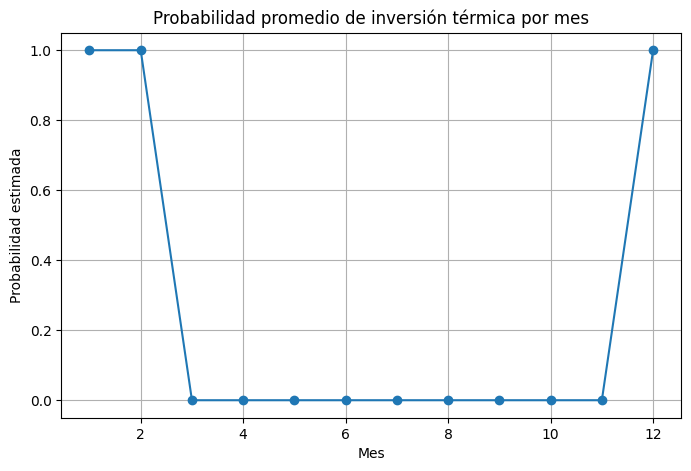

In [ ]:
# CHUNK 8 — Gráfico de probabilidad por mes
import matplotlib.pyplot as plt

prob_mes = df_model.groupby('mes')['inversion_termica'].mean()

plt.figure(figsize=(8,5))
plt.plot(prob_mes.index, prob_mes.values, marker='o')
plt.title('Probabilidad promedio de inversión térmica por mes')
plt.xlabel('Mes')
plt.ylabel('Probabilidad estimada')
plt.grid(True)
plt.show()
